# Session 4 — Paragraph-Level Analysis
## Measure 1: Paragraph Semantic Coherence

In this notebook, you will:
- split your text into paragraphs and sentences
- compute **embedding-based coherence** per paragraph using MiniLM
- compare coherence distributions across two books
- connect this to how RAG systems and LLMs assess chunk quality

We again use Lewis Carroll's *Alice* books as examples. Replace the file
paths with your own author/text for your project.


In [2]:
import re
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    """Load and lightly clean a book text (Project Gutenberg style)."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    # Very simple Project Gutenberg cleaner (adapt to your own corpus)
    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

# Load both Alice books (replace with your own paths)
crime_text = load_book('../data/Crime-punishment.txt')
brothers_karamazov_text = load_book('../data/The-Brotherskaramazov.txt')

print(f"Crime and Punishment characters: {len(crime_text):,}")
print(f"The Brothers Karamazov characters: {len(brothers_karamazov_text):,}")

c:\Users\moham\NLP_w4\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Crime and Punishment characters: 1,224,428
The Brothers Karamazov characters: 1,956,237


In [3]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """Split raw text into paragraphs using blank lines as boundaries.
    Filters out very short paragraphs (e.g. chapter titles)."""
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def sentence_split(paragraph: str) -> List[str]:
    """Very simple sentence splitter based on punctuation."""
    sentences = re.split(r'[.!?]+\s+', paragraph.strip())
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[list, list]:
    """Compute embedding-based coherence for each paragraph.

    Steps:
    - Split each paragraph into sentences
    - Compute MiniLM embeddings for all sentences
    - Compute the centroid (mean embedding) for the paragraph
    - Coherence = average cosine similarity of each sentence
      to the centroid embedding
    """
    scores = []
    lengths = []
    for p in paragraphs:
        sents = sentence_split(p)
        if len(sents) < 2:
            continue
        # Encode all sentences in this paragraph
        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]
        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
    return scores, lengths

crime_paras = split_into_paragraphs(crime_text)
brothers_karamazov_paras = split_into_paragraphs(brothers_karamazov_text)

c_scores, c_lengths = paragraph_coherence_embeddings(crime_paras)
b_scores, b_lengths = paragraph_coherence_embeddings(brothers_karamazov_paras)
print(f"Crime and Punishment mean coherence (embeddings): {sum(c_scores)/len(c_scores):.3f}")
print(f"The Brothers Karamazov mean coherence (embeddings): {sum(b_scores)/len(b_scores):.3f}")

Crime and Punishment mean coherence (embeddings): 0.519
The Brothers Karamazov mean coherence (embeddings): 0.688


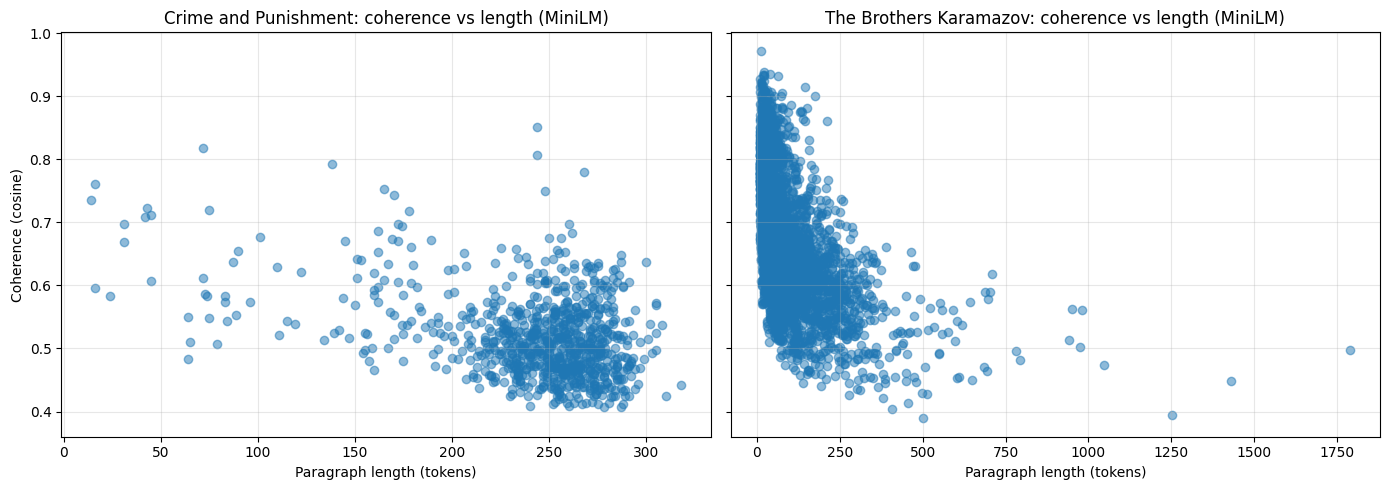

In [7]:
# Visualize coherence vs paragraph length
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].scatter(c_lengths, c_scores, alpha=0.5)
axes[0].set_title("Crime and Punishment: coherence vs length (MiniLM)")
axes[0].set_xlabel("Paragraph length (tokens)")
axes[0].set_ylabel("Coherence (cosine)")
axes[0].grid(True, alpha=0.3)

axes[1].scatter(b_lengths, b_scores, alpha=0.5)
axes[1].set_title("The Brothers Karamazov: coherence vs length (MiniLM)")
axes[1].set_xlabel("Paragraph length (tokens)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


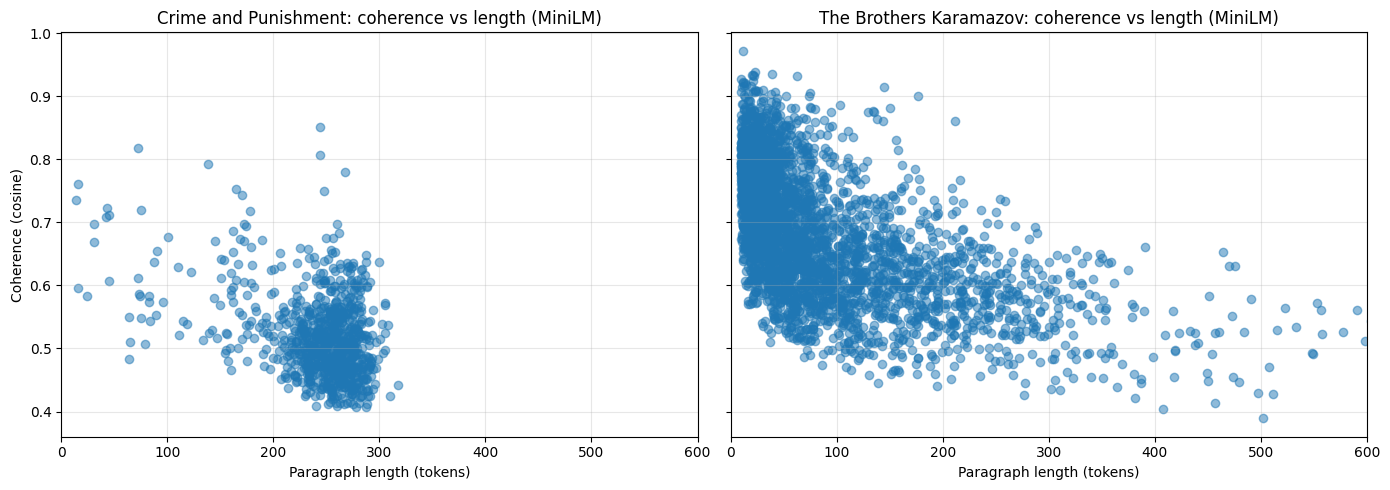

In [6]:
# Visualize coherence vs paragraph length
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].scatter(c_lengths, c_scores, alpha=0.5)
axes[0].set_title("Crime and Punishment: coherence vs length (MiniLM)")
axes[0].set_xlabel("Paragraph length (tokens)")
axes[0].set_ylabel("Coherence (cosine)")
axes[0].set_xlim(0, 600)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(b_lengths, b_scores, alpha=0.5)
axes[1].set_title("The Brothers Karamazov: coherence vs length (MiniLM)")
axes[1].set_xlabel("Paragraph length (tokens)")
axes[1].set_xlim(0, 600)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


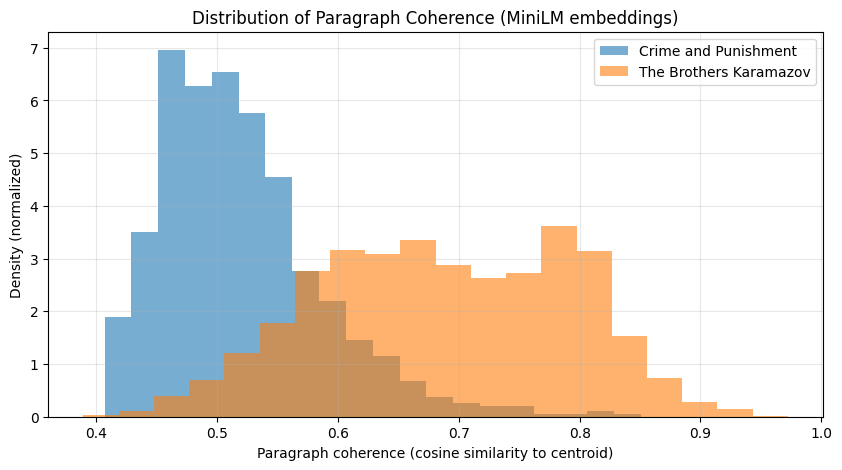

In [8]:
# Compare distributions with histograms
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(c_scores, bins=20, alpha=0.6, label='Crime and Punishment', density=True)
ax.hist(b_scores, bins=20, alpha=0.6, label='The Brothers Karamazov', density=True)
ax.set_xlabel('Paragraph coherence (cosine similarity to centroid)')
ax.set_ylabel('Density (normalized)')
ax.set_title('Distribution of Paragraph Coherence (MiniLM embeddings)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [10]:
import gc

# Delete large variables to free memory
del crime_text, brothers_karamazov_text
del crime_paras, brothers_karamazov_paras
del c_scores, c_lengths, b_scores, b_lengths

# Clear matplotlib figures
plt.close('all')

# Unload the model from memory
del model

# Force garbage collection
gc.collect()

print("Memory cleaned! Large variables deleted and garbage collected.")

Memory cleaned! Large variables deleted and garbage collected.
